# Import Libraries

In [69]:
#importing the required libraries
import pandas as pd
import numpy as np
from collections import Counter

#viz Libraries
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.style as style
import matplotlib.gridspec as gridspec
import seaborn as sns
from mpl_toolkits import mplot3d
from scipy import stats
%matplotlib inline

#warnings
import warnings
warnings.filterwarnings("ignore")

#datetime processing
import datetime as dt

#Preproceesing
from sklearn import preprocessing
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
import pandas_profiling as pp

# models
from sklearn.linear_model import LinearRegression,LogisticRegression, SGDRegressor, RidgeCV
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor
import sklearn.model_selection
from sklearn.model_selection import cross_val_predict as cvp
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import xgboost as xgb
from sklearn.cluster import KMeans

#For Natural Language Processing (medical)
import scispacy
import spacy

# Functions

In [70]:
def most_k(numbers, k=1):
    '''
    Function to return the most reoccurring
    values in a column
    '''
    c = Counter(numbers)
    most_common = [key for key, val in c.most_common(k)]

    return most_common

In [71]:
def age_category(df):
    '''
    Categorization of the Age
    '''
    if (df['AGE'] <= 1):
        return 'Infants'
    elif (df['AGE'] >= 2) and (df['AGE'] <= 11): 
        return 'adolescent'
    elif (df['AGE'] >= 12) and (df['AGE'] <= 19):
        return 'Teens'
    elif (df['AGE'] >= 20) and (df['AGE'] <= 35):
        return 'Young Adults'
    elif (df['AGE'] >= 36) and (df['AGE'] <= 65):
        return 'Old Adults'
    elif (df['AGE'] >= 66):
        return 'Old'


In [72]:
def identify_disease(df):
    '''
    This function uses the spacy pipeline to identify disease diagnosed from diagnosis column
    '''
    df1 = nlp(df)
    df2 = [w.text for w in df1.ents]
    return df2

In [73]:
def rfm_level(df):
    '''
    Define rfm_level
    '''
    if np.bool(df['RFM_Score'] >= 10):
        return 'High Claim Hospital'
    elif np.bool((df['RFM_Score'] < 10) & (df['RFM_Score'] >= 6)):
        return 'Mid-level Claim Hospital'
    else:
        return 'Low Claim Hospital'

In [74]:
def split_by_fractions(df:pd.DataFrame, fracs:list, random_state:int=42):
    '''
    Function to split data based on specified fraction
    '''
    assert sum(fracs)==1.0, 'fractions sum is not 1.0 (fractions_sum={})'.format(sum(fracs))
    remain = df.index.copy().to_frame()
    res = []
    for i in range(len(fracs)):
        fractions_sum=sum(fracs[i:])
        frac = fracs[i]/fractions_sum
        idxs = remain.sample(frac=frac, random_state=random_state).index
        remain=remain.drop(idxs)
        res.append(idxs)
    return [df.loc[idxs] for idxs in res]

In [75]:
def acc_rmse(y_meas, y_pred):
    '''
    RMSE between predicted y_pred and measured y_meas value
    '''
    return (mean_squared_error(y_meas, y_pred))**0.5

In [76]:
def acc_boosting_model(num,model,train,test,num_iteration=0):
    '''
    Calculation of accuracy of boosting model by RMSE
    '''
    
    global acc_train_rmse, acc_test_rmse
    
    if num_iteration > 0:
        ytrain = model.predict(train, num_iteration = num_iteration)  
        ytest = model.predict(test, num_iteration = num_iteration)
    else:
        ytrain = model.predict(train)  
        ytest = model.predict(test)

    print('target = ', target_train[:5].values)
    print('ytrain = ', ytrain[:5])

    acc_train_rmse_num = round(acc_rmse(target_train, ytrain) * 100, 2)
    print('acc(rmse) for train =', acc_train_rmse_num)   
    acc_train_rmse.insert(num, acc_train_rmse_num)
    
    acc_test_rmse_num = round(acc_rmse(target_test, ytest) * 100, 2)
    print('acc(rmse) for test =', acc_test_rmse_num)
    acc_test_rmse.insert(num, acc_test_rmse_num)

In [77]:
def acc_model(num,model,train,test):
    '''
    Calculating the accuracy of the model using RMSE
    '''   
  
    global acc_train_rmse, acc_test_rmse
    
    ytrain = model.predict(train)  
    ytest = model.predict(test)

    acc_train_rmse_num = round(acc_rmse(target_train, ytrain) * 100, 2)
    print('acc(rmse) for train =', acc_train_rmse_num)   
    acc_train_rmse.insert(num, acc_train_rmse_num)
    
    acc_test_rmse_num = round(acc_rmse(target_test, ytest) * 100, 2)
    print('acc(rmse) for test =', acc_test_rmse_num)
    acc_test_rmse.insert(num, acc_test_rmse_num)

# Dataset

In [78]:
df = pd.read_excel('/Users/josehpoladokun/Downloads/Claims Data _ RHData Scientist Test (070520) (1).xlsx')

In [79]:
df.head()

S/N  AGE SEX               PLAN    COMPANY       PROVIDER NAME  \
0    1   29   M     RED Individual  CORPORATE  JOY HOSPITAL-LAGOS   
1    2   31   F  Yellow Individual  CORPORATE  CHARMAINE HOSPITAL   
2    3   31   F  Yellow Individual  CORPORATE  CHARMAINE HOSPITAL   
3    4   23   M  Yellow Individual  CORPORATE   CILANTRO HOSPITAL   
4    5   30   F     RED Individual  CORPORATE  JOY HOSPITAL-LAGOS   

  PATIENT ENCOUNTER DATE MEDICAL CLAIMS SUBMISSION DATE PAYMENT DATE  \
0             1997-12-12                     1998-01-02   1998-01-02   
1             1997-12-24                     1998-01-02   1998-01-02   
2             1997-12-28                     1998-01-02   1998-01-02   
3             1997-12-19                     1998-01-03   1998-01-09   
4             1997-12-01                     1998-01-04   1998-01-09   

  SERVICE TYPE                       DIAGNOSIS  TOTAL PRICE  
0   Outpatient         ACUTE MALARIA WITH URTI     17000.00  
1   Outpatient  LEFT MODERATE TO PROFOUND SNHL     20000.00  
2    Inpatient  LEFT MODERATE TO PROFOUND SNHL     15000.00  
3   Outpatient                            URTI      2160.00  
4   Outpatient                    PLASMODIASIS     10399.99

In [80]:
#Checking data types
df.dtypes

S/N                                        int64
AGE                                        int64
SEX                                       object
PLAN                                      object
COMPANY                                   object
PROVIDER NAME                             object
PATIENT ENCOUNTER DATE            datetime64[ns]
MEDICAL CLAIMS SUBMISSION DATE    datetime64[ns]
PAYMENT DATE                      datetime64[ns]
SERVICE TYPE                              object
DIAGNOSIS                                 object
TOTAL PRICE                              float64
dtype: object

In [81]:
#Categorize the age and creating the age_category column
df['age_category'] = df.apply(age_category, axis=1)

## Most Common Plan Among Retailers and How it vary between Sex and Age Groups

To Answer the question:

1. Most Common Plan Among Retailer

In [82]:
#Get data for retailers
df_retail = df.loc[df['COMPANY'] == 'RETAIL']
df_retail.head()

S/N  AGE SEX               PLAN COMPANY  \
37   38   23   M     RED Individual  RETAIL   
39   40   30   M  Yellow Individual  RETAIL   
41   42    3   M     RED Individual  RETAIL   
42   43   28   M     RED Individual  RETAIL   
50   51    7   F  Yellow Individual  RETAIL   

                          PROVIDER NAME PATIENT ENCOUNTER DATE  \
37          SHAKIRAT  HOSPITAL - EGBEDA             1998-02-04   
39        RECOVERY MEDICAL SERVICES LTD             1998-02-06   
41        SOLUTIONS SPECIALIST HOSPITAL             1998-02-21   
42                      HONEY  HOSPITAL             1998-02-26   
50  HOSANNA  CHILDREN'S HOSPITAL- OKOTA             1998-02-20   

   MEDICAL CLAIMS SUBMISSION DATE PAYMENT DATE SERVICE TYPE  \
37                     1998-02-16   1998-02-21   Outpatient   
39                     1998-02-21   1998-02-21   Outpatient   
41                     1998-02-22   1998-02-22   Outpatient   
42                     1998-02-26   1998-03-03   Outpatient   
50                     1998-03-01   1998-03-03   Outpatient   

                                            DIAGNOSIS  TOTAL PRICE  \
37  Plasmodiasis R/O Enteric Fever,Gastro oesphagu...      5143.80   
39                             HEADACHE AND SINUSITIS     18580.00   
41         Acute  tonsillitis , severe malaria + urti      4834.95   
42                                         Dermatitis      2300.00   
50                             FOREIGN BODY IN THROAT      4375.00   

    age_category  
37  Young Adults  
39  Young Adults  
41    adolescent  
42  Young Adults  
50    adolescent

In [83]:
#The most commonn plan
most_k(df_retail['PLAN'], k=1)

['RED Individual']

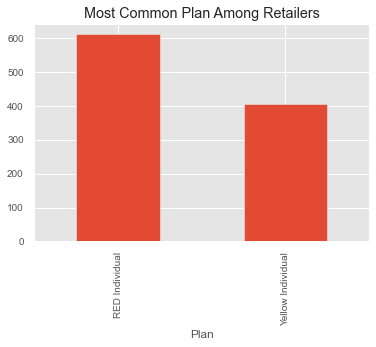

In [84]:
#Visualization for the most common plan
fig, ax = plt.subplots()
df_retail['PLAN'].value_counts().plot(ax=ax, kind='bar')
ax.set_xlabel('Plan')
ax.set_title('Most Common Plan Among Retailers')
plt.show()

How Plan vary Between Age gruop and sex

In [85]:
#Get the individuals with Red individual plan from retail
df_retail_red = df_retail.loc[df_retail['PLAN'] == 'RED Individual']
df_retail_red.head()

S/N  AGE SEX            PLAN COMPANY                  PROVIDER NAME  \
37   38   23   M  RED Individual  RETAIL    SHAKIRAT  HOSPITAL - EGBEDA   
41   42    3   M  RED Individual  RETAIL  SOLUTIONS SPECIALIST HOSPITAL   
42   43   28   M  RED Individual  RETAIL                HONEY  HOSPITAL   
52   53   27   F  RED Individual  RETAIL    SHAKIRAT  HOSPITAL - EGBEDA   
53   54   27   F  RED Individual  RETAIL    SHAKIRAT  HOSPITAL - EGBEDA   

   PATIENT ENCOUNTER DATE MEDICAL CLAIMS SUBMISSION DATE PAYMENT DATE  \
37             1998-02-04                     1998-02-16   1998-02-21   
41             1998-02-21                     1998-02-22   1998-02-22   
42             1998-02-26                     1998-02-26   1998-03-03   
52             1998-02-25                     1998-02-26   1998-03-09   
53             1998-02-25                     1998-02-26   1998-03-09   

   SERVICE TYPE                                          DIAGNOSIS  \
37   Outpatient  Plasmodiasis R/O Enteric Fever,Gastro oesphagu...   
41   Outpatient         Acute  tonsillitis , severe malaria + urti   
42   Outpatient                                         Dermatitis   
52   Outpatient                                                uti   
53   Outpatient                            uti,plasmodiasis,sepsis   

    TOTAL PRICE  age_category  
37      5143.80  Young Adults  
41      4834.95    adolescent  
42      2300.00  Young Adults  
52      1600.00  Young Adults  
53      4717.50  Young Adults

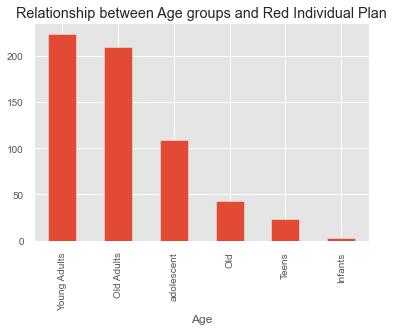

In [86]:
fig, ax = plt.subplots()
df_retail_red['age_category'].value_counts().plot(ax=ax, kind='bar')
ax.set_xlabel('Age')
ax.set_title('Relationship between Age groups and Red Individual Plan')
plt.show()

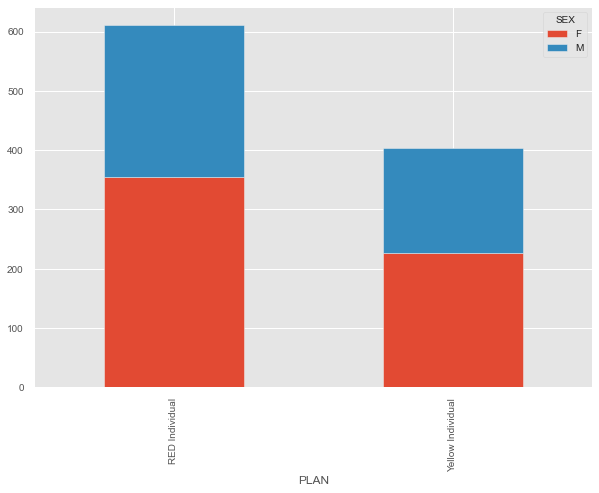

In [87]:
#Visualizing relationship between Plan and the Sex

df_retail2 = df.loc[df['COMPANY'] == 'RETAIL'].groupby(['SEX','PLAN']).size().reset_index(name='Count')
df3 = pd.pivot_table(df_retail2,  values='Count',  columns=['SEX'],  index = "PLAN",
                         aggfunc=np.sum,  fill_value=0)
df3.plot(kind="bar",stacked=True, figsize=(10,7))
plt.show()

There are more female in both Plan category

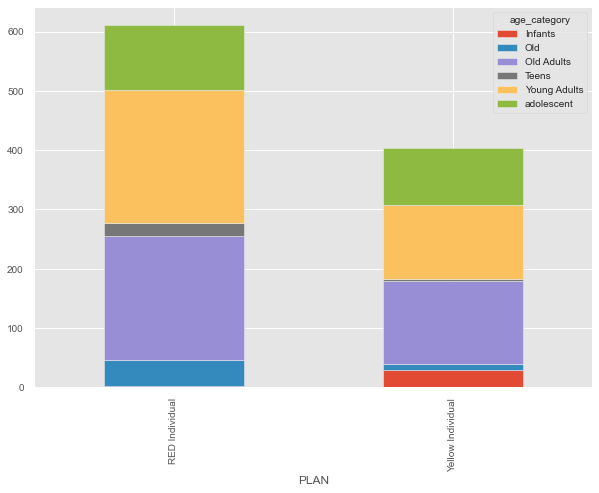

In [88]:
#Visualizing the relationship between Plan and Age Category

df_retail2 = df.loc[df['COMPANY'] == 'RETAIL'].groupby(['age_category','PLAN']).size().reset_index(name='Count')
df3 = pd.pivot_table(df_retail2,  values='Count',  columns=['age_category'],  index = "PLAN",
                         aggfunc=np.sum,  fill_value=0)
df3.plot(kind="bar",stacked=True, figsize=(10,7))
plt.show()

Unsurprisingly, The Young Adult (20-35 years old) and Old Adult (35-65 years old) dominate both categoroies

## Relationship between Plan and Provider and Price

In [89]:
#subset the concerned columns
df_subset = df[['PLAN','PROVIDER NAME','TOTAL PRICE']]

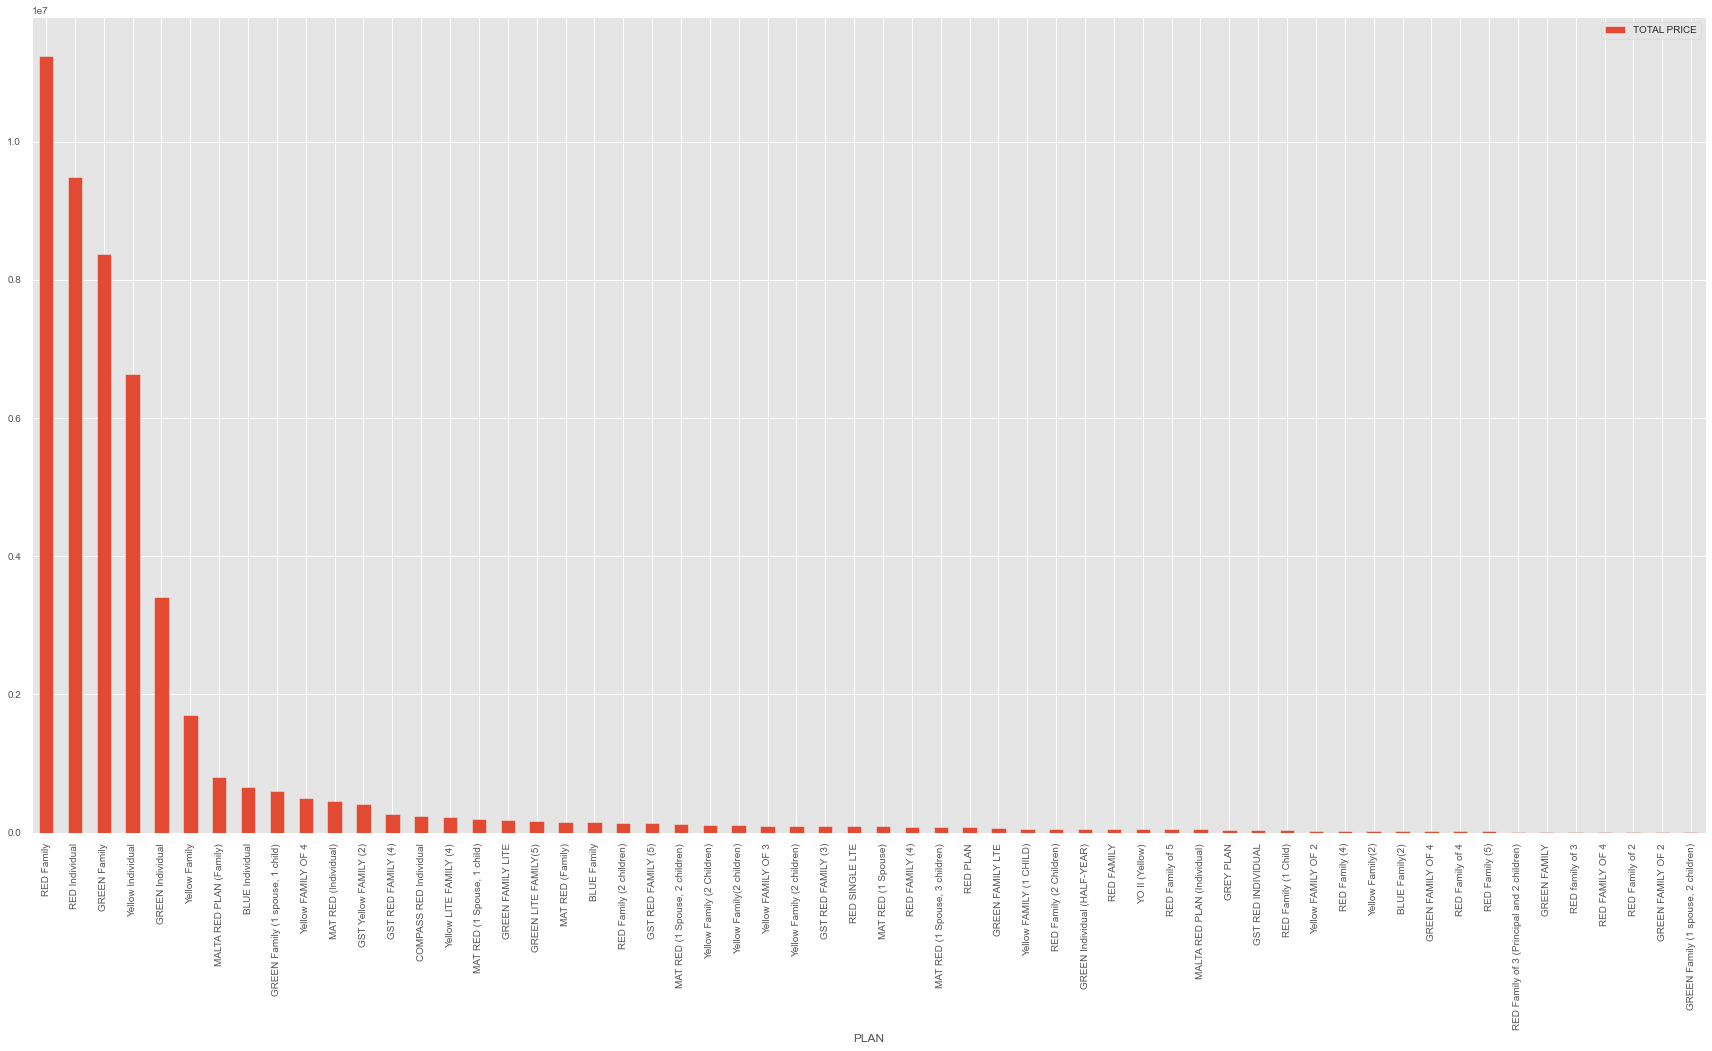

In [90]:
#Aggregate it by plan with price as values and visualize
df_plan_price = df_subset.groupby(['PLAN']).sum().sort_values('TOTAL PRICE', ascending=False).plot.bar(figsize=(30,15))

The chart shows that the top 5 most payment was made on the following plan
- Red Family
- Red Individual
- Green Family
- Yellow Family
- Malta Red Plan Family

In [91]:
#The Aggregation of Provider name, Plan and Price
df_price_provider = df_subset.groupby(['PROVIDER NAME','PLAN']).sum().sort_values('TOTAL PRICE', ascending=False)
df_price_provider.head()

TOTAL PRICE
PROVIDER NAME                   PLAN                          
WELLNESS CLINICS                GREEN Family        1123538.00
RIBENA  HOSPITAL                GREEN Family        1039422.90
LEILA CHILDREN HOSPITAL - LEKKI Yellow Individual    846795.00
CHARMAINE HOSPITAL              Yellow Individual    792150.00
KEZIAH HOSPITAL                 GREEN Family         709788.85

The table above shows the top 5 hospitals with the plan that recieved most insurance claims

## Relationship between Submission Gap and Diagnosis

We will implement the NLP Spacy pipeline to extract names of disease from the diagnosis column

In [92]:
#load the full spaCy pipeline for biomedical data with a larger vocabulary and 50k word vectors.
nlp = spacy.load("en_core_sci_md")

In [93]:
#Getting the diseases using the identify disease function
df['diag_keyword'] = df['DIAGNOSIS'].apply(identify_disease)

In [94]:
df.head()

S/N  AGE SEX               PLAN    COMPANY       PROVIDER NAME  \
0    1   29   M     RED Individual  CORPORATE  JOY HOSPITAL-LAGOS   
1    2   31   F  Yellow Individual  CORPORATE  CHARMAINE HOSPITAL   
2    3   31   F  Yellow Individual  CORPORATE  CHARMAINE HOSPITAL   
3    4   23   M  Yellow Individual  CORPORATE   CILANTRO HOSPITAL   
4    5   30   F     RED Individual  CORPORATE  JOY HOSPITAL-LAGOS   

  PATIENT ENCOUNTER DATE MEDICAL CLAIMS SUBMISSION DATE PAYMENT DATE  \
0             1997-12-12                     1998-01-02   1998-01-02   
1             1997-12-24                     1998-01-02   1998-01-02   
2             1997-12-28                     1998-01-02   1998-01-02   
3             1997-12-19                     1998-01-03   1998-01-09   
4             1997-12-01                     1998-01-04   1998-01-09   

  SERVICE TYPE                       DIAGNOSIS  TOTAL PRICE  age_category  \
0   Outpatient         ACUTE MALARIA WITH URTI     17000.00  Young Adults   
1   Outpatient  LEFT MODERATE TO PROFOUND SNHL     20000.00  Young Adults   
2    Inpatient  LEFT MODERATE TO PROFOUND SNHL     15000.00  Young Adults   
3   Outpatient                            URTI      2160.00  Young Adults   
4   Outpatient                    PLASMODIASIS     10399.99  Young Adults   

       diag_keyword  
0   [MALARIA, URTI]  
1  [PROFOUND, SNHL]  
2  [PROFOUND, SNHL]  
3            [URTI]  
4    [PLASMODIASIS]

In [95]:
#Cleaning the output
df['diag'] = [','.join(map(str, l)) for l in df['diag_keyword']]
df = df.drop(['diag_keyword'], axis=1)

In [96]:
#Getting the Submission Gap, which is the diffrence in MEDICAL CLAIMS SUBMISSION DATE and PATIENT ENCOUNTER DATE
df['Submission_Gap'] = (df['MEDICAL CLAIMS SUBMISSION DATE'] - df['PATIENT ENCOUNTER DATE']).dt.days

In [97]:
#Subset the concern column
df_sub = df[['diag', 'Submission_Gap']]

In [98]:
#Checking for missing values
df_sub.isnull().values.any()

False

In [99]:
#Aggregate the subset with diag as index
df_s = df_sub.groupby(['diag']).mean().sort_values('Submission_Gap', ascending=False)

In [100]:
#Getting the top 10
df_top10 = df_s.head(10)

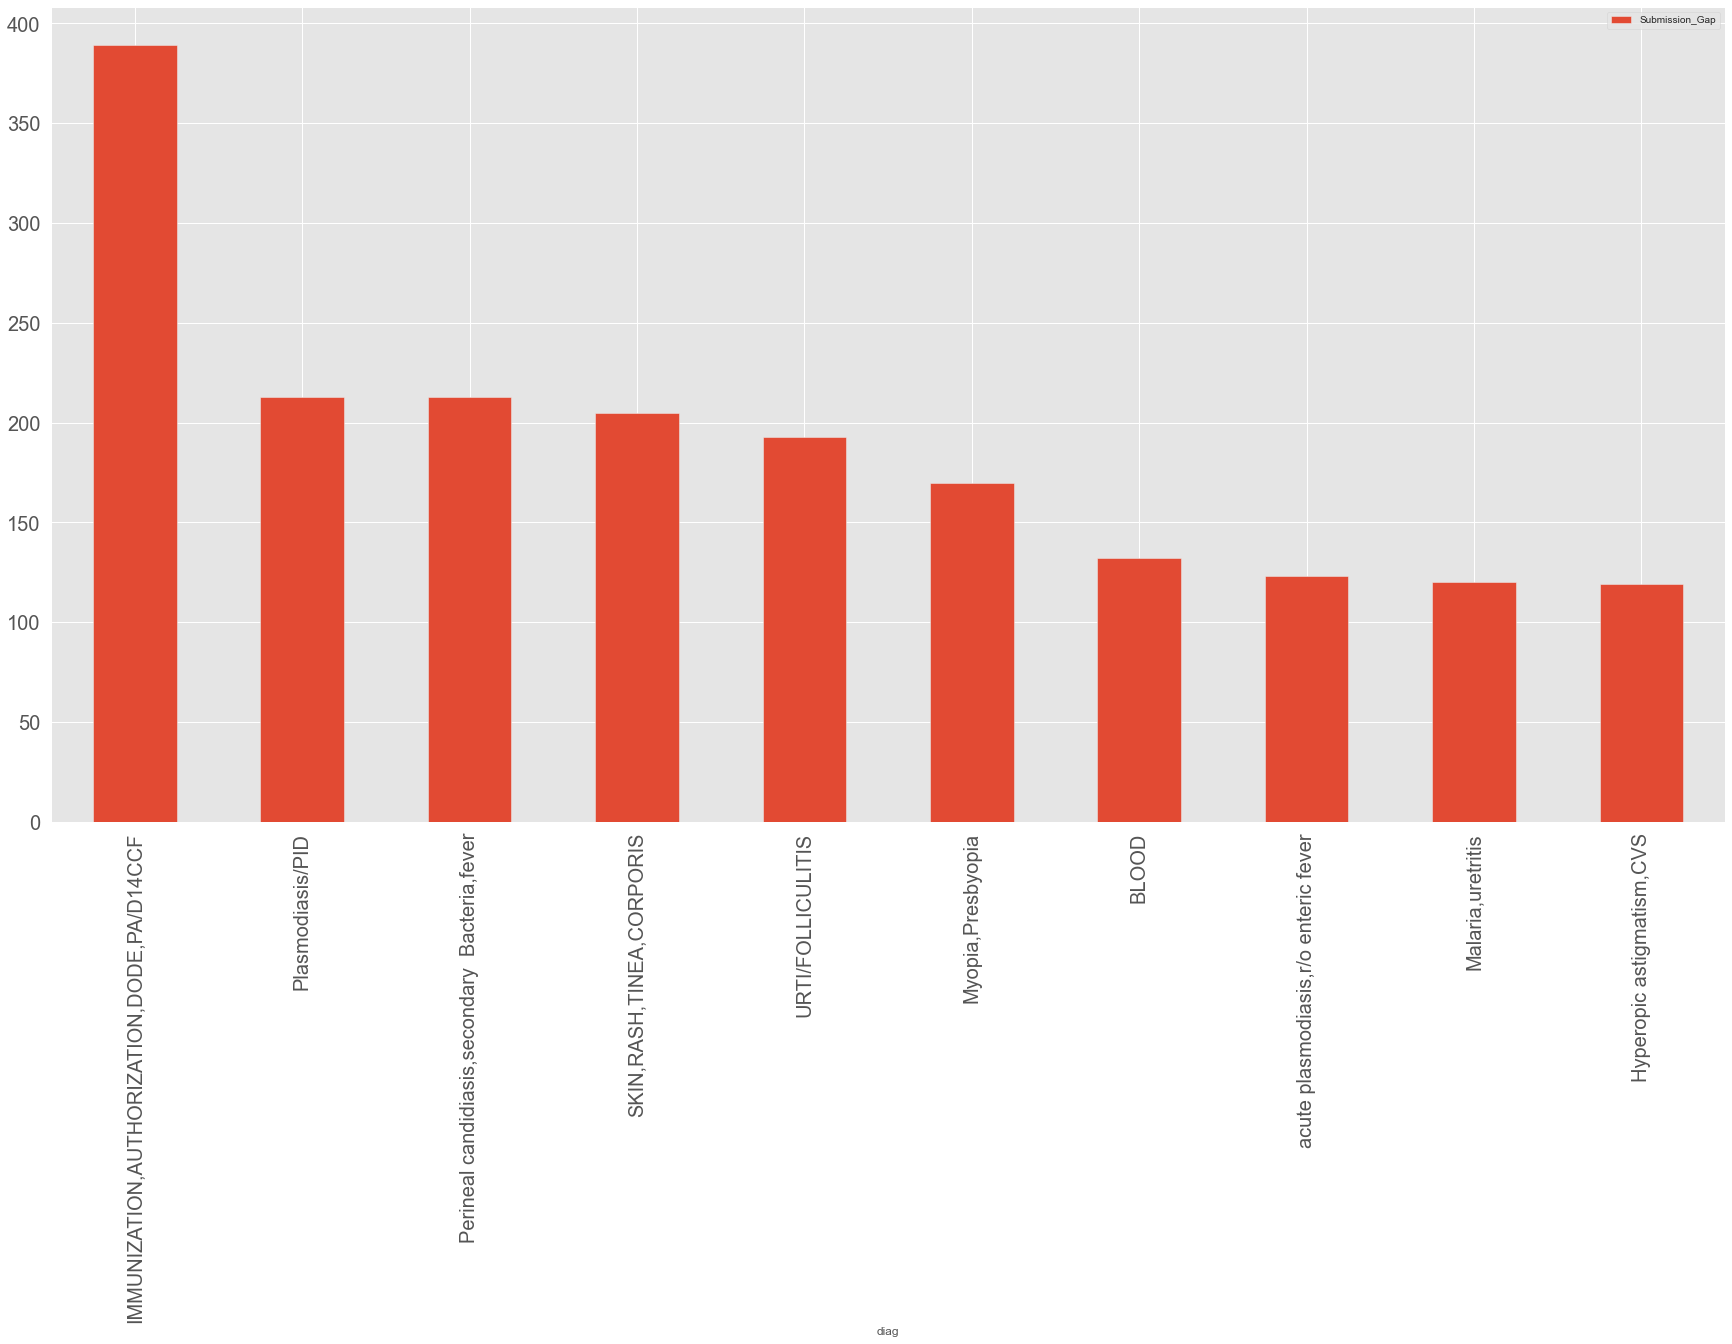

In [101]:
#Visualizing the relationship between Diagnosis and Submission Gap
df_top10.plot.bar(figsize=(30,15), fontsize = 20)

The top diagnosis with the highest submission gap include:
- IMMUNIZATION,AUTHORIZATION,DODE,PA/D14CCF
- Plasmodiasis/PID
- Perineal candidiasis,secondary Bacteria,fever

## Relationship Between Encounter date and Diagnosis

In [102]:
#Subset relevant Column
df_pg = df[['PATIENT ENCOUNTER DATE', 'diag']]

In [103]:
#Aggregate the data
df_pg_agg = df_pg.groupby(['PATIENT ENCOUNTER DATE']).count()

In [104]:
#Sort the data
df_pg_agg.sort_values('diag', ascending=False)

diag
PATIENT ENCOUNTER DATE      
1998-10-08                42
1999-01-14                41
1999-01-15                41
1998-10-15                40
1999-01-16                40
...                      ...
1998-03-20                 1
1998-03-14                 1
1998-03-10                 1
1998-03-09                 1
1999-02-27                 1

[407 rows x 1 columns]

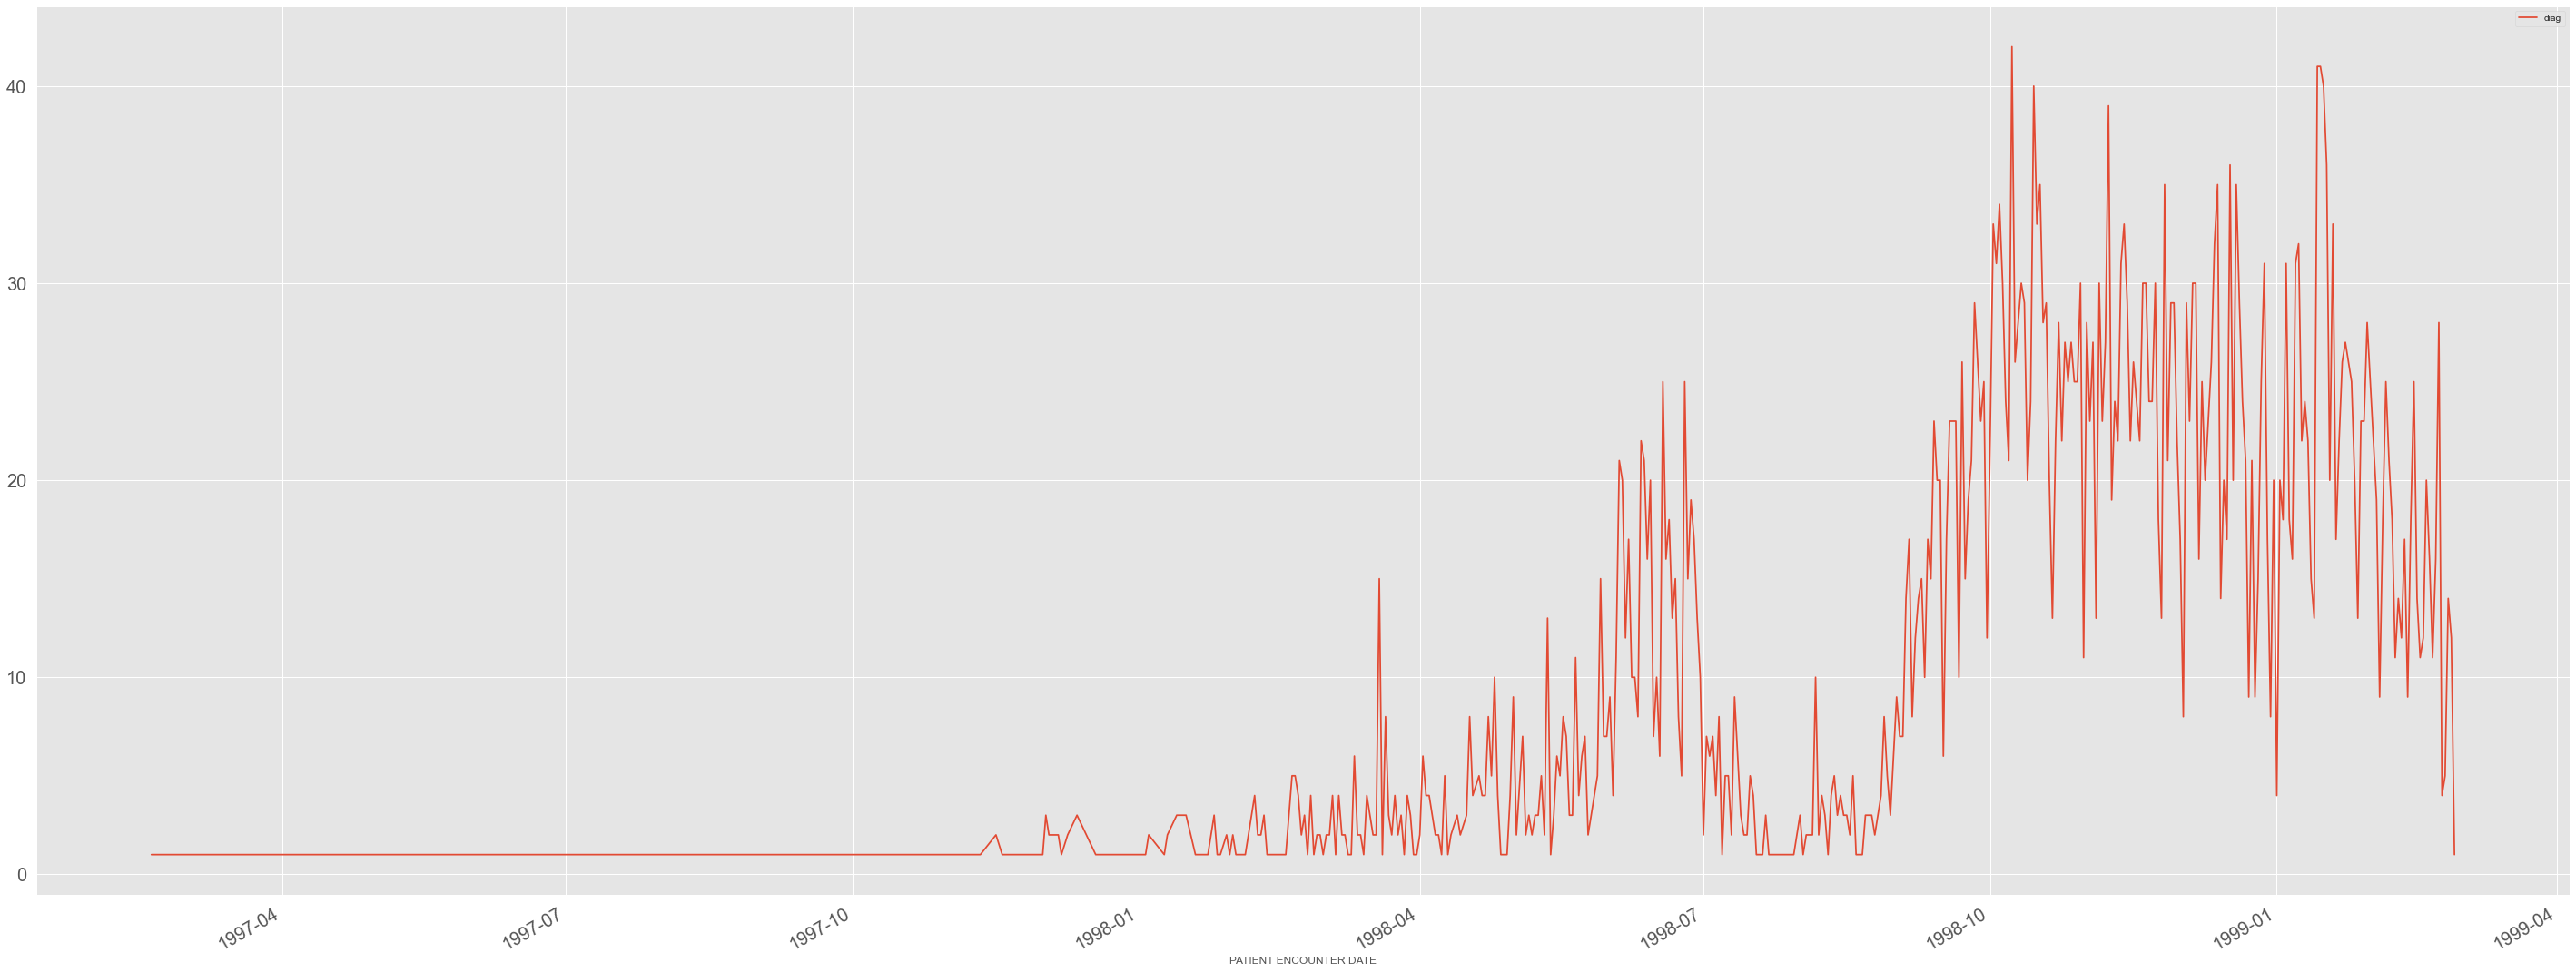

In [105]:
#Visualizing the timerseries
df_pg_agg.plot.line(figsize=(50,20), fontsize = 20)

The top 5 patient encounter dates with the highest number of diagnosis is 
- 1998-10-08
- 1999-01-14
- 1999-01-15
- 1998-10-15
- 1999-01-16

The Chart also shows a sudden spike in number of diagnosis around March and August 1998. There's also an increase in average diagnosis between October 1998 and March 1999

## Relationship Between Service Type and Total Price

In [106]:
#Subset relevant data
df_sub2 = df[['SERVICE TYPE', 'TOTAL PRICE']]

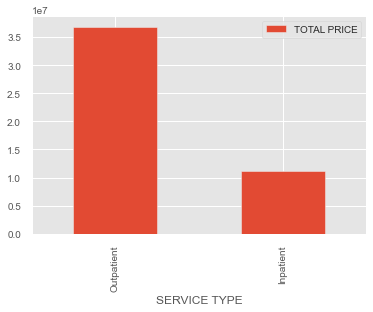

In [107]:
#Plot the relationship
df_service = df_sub2.groupby(['SERVICE TYPE']).sum().sort_values('TOTAL PRICE', ascending=False).plot.bar()

More claims has been paid to Outpatient service type

# Segmentation and Clustering

We will first calculate Recency, Frequency and Monetary Value of each Provider (Hospital). We can't create cluster at customers level because tghere's no unique identify for them

- Recency : Recency is the number of days between the hospiatls's latest payment data and the snapshot date
- Frequency: Number of claims coming from the hospital
- MonetaryValue: Total amount of money paid to the hospital

In [108]:
#Getting the number of claims coming from each hospital
df['NUMBEROFCLAIMS']= df['PROVIDER NAME'].map(df['PROVIDER NAME'].value_counts())
df.head()

S/N  AGE SEX               PLAN    COMPANY       PROVIDER NAME  \
0    1   29   M     RED Individual  CORPORATE  JOY HOSPITAL-LAGOS   
1    2   31   F  Yellow Individual  CORPORATE  CHARMAINE HOSPITAL   
2    3   31   F  Yellow Individual  CORPORATE  CHARMAINE HOSPITAL   
3    4   23   M  Yellow Individual  CORPORATE   CILANTRO HOSPITAL   
4    5   30   F     RED Individual  CORPORATE  JOY HOSPITAL-LAGOS   

  PATIENT ENCOUNTER DATE MEDICAL CLAIMS SUBMISSION DATE PAYMENT DATE  \
0             1997-12-12                     1998-01-02   1998-01-02   
1             1997-12-24                     1998-01-02   1998-01-02   
2             1997-12-28                     1998-01-02   1998-01-02   
3             1997-12-19                     1998-01-03   1998-01-09   
4             1997-12-01                     1998-01-04   1998-01-09   

  SERVICE TYPE                       DIAGNOSIS  TOTAL PRICE  age_category  \
0   Outpatient         ACUTE MALARIA WITH URTI     17000.00  Young Adults   
1   Outpatient  LEFT MODERATE TO PROFOUND SNHL     20000.00  Young Adults   
2    Inpatient  LEFT MODERATE TO PROFOUND SNHL     15000.00  Young Adults   
3   Outpatient                            URTI      2160.00  Young Adults   
4   Outpatient                    PLASMODIASIS     10399.99  Young Adults   

            diag  Submission_Gap  NUMBEROFCLAIMS  
0   MALARIA,URTI              21              44  
1  PROFOUND,SNHL               9              87  
2  PROFOUND,SNHL               5              87  
3           URTI              15              46  
4   PLASMODIASIS              34              44

In [109]:
# Calculate Recency, Frequency and Monetary value for each hospital
snapshot_date = df['MEDICAL CLAIMS SUBMISSION DATE'].max() + dt.timedelta(days=1) #latest date in the data set
df_RFM = df.groupby(['PROVIDER NAME']).agg({
    'MEDICAL CLAIMS SUBMISSION DATE': lambda x: (snapshot_date - x.max()).days,
    'NUMBEROFCLAIMS': 'count',
    'TOTAL PRICE':'sum'})

In [110]:
#Renaming the columns
df_RFM.rename(columns={'MEDICAL CLAIMS SUBMISSION DATE': 'Recency',
                   'NUMBEROFCLAIMS': 'Frequency',
                   'TOTALPRICE': 'MonetaryValue'}, inplace=True)

In [111]:
df_RFM.head()

Recency  Frequency  TOTAL PRICE
PROVIDER NAME                                                  
 DOLAPO RADIOLOGY                    22          1     12240.00
ABIMBOLA HEALTH CENTRE                2          9     39330.00
ABROAD MEDICAL CENTRE                19         36    173910.25
ACRES HOSPITAL LTD                   28          6     92902.00
ADEOLA  HOSPITAL AND MATERNITY       85          8     28500.52

## Dividing into segments

In [112]:
# Create a spend quartile with 4 groups - a range between 1 and 5
TOTALPRICE_quartile = pd.qcut(df_RFM['TOTAL PRICE'], q=4, labels=range(1,5))
Recency_quartile = pd.qcut(df_RFM['Recency'], q=4, labels=list(range(4, 0, -1)))
Frequency_quartile = pd.qcut(df_RFM['Frequency'], q=4, labels=range(1,5))

In [113]:
# Assign the quartile values to the Spend_Quartile column in data
df_RFM['R'] = Recency_quartile
df_RFM['F'] = Frequency_quartile
df_RFM['M'] = TOTALPRICE_quartile

df_RFM.head()

Recency  Frequency  TOTAL PRICE  R  F  M
PROVIDER NAME                                                           
 DOLAPO RADIOLOGY                    22          1     12240.00  3  1  1
ABIMBOLA HEALTH CENTRE                2          9     39330.00  4  3  2
ABROAD MEDICAL CENTRE                19         36    173910.25  3  4  4
ACRES HOSPITAL LTD                   28          6     92902.00  2  2  3
ADEOLA  HOSPITAL AND MATERNITY       85          8     28500.52  1  3  2

In [114]:
# Calculate RFM_Score
df_RFM['RFM_Score'] = df_RFM[['R','F','M']].sum(axis=1)
df_RFM.head()

Recency  Frequency  TOTAL PRICE  R  F  M  \
PROVIDER NAME                                                              
 DOLAPO RADIOLOGY                    22          1     12240.00  3  1  1   
ABIMBOLA HEALTH CENTRE                2          9     39330.00  4  3  2   
ABROAD MEDICAL CENTRE                19         36    173910.25  3  4  4   
ACRES HOSPITAL LTD                   28          6     92902.00  2  2  3   
ADEOLA  HOSPITAL AND MATERNITY       85          8     28500.52  1  3  2   

                                RFM_Score  
PROVIDER NAME                              
 DOLAPO RADIOLOGY                     5.0  
ABIMBOLA HEALTH CENTRE                9.0  
ABROAD MEDICAL CENTRE                11.0  
ACRES HOSPITAL LTD                    7.0  
ADEOLA  HOSPITAL AND MATERNITY        6.0

In [115]:
# Create a new variable RFM_Level by aplying the rfm level function
df_RFM['RFM_Level'] = df_RFM.apply(rfm_level, axis=1)
df_RFM.head()

Recency  Frequency  TOTAL PRICE  R  F  M  \
PROVIDER NAME                                                              
 DOLAPO RADIOLOGY                    22          1     12240.00  3  1  1   
ABIMBOLA HEALTH CENTRE                2          9     39330.00  4  3  2   
ABROAD MEDICAL CENTRE                19         36    173910.25  3  4  4   
ACRES HOSPITAL LTD                   28          6     92902.00  2  2  3   
ADEOLA  HOSPITAL AND MATERNITY       85          8     28500.52  1  3  2   

                                RFM_Score                 RFM_Level  
PROVIDER NAME                                                        
 DOLAPO RADIOLOGY                     5.0        Low Claim Hospital  
ABIMBOLA HEALTH CENTRE                9.0  Mid-level Claim Hospital  
ABROAD MEDICAL CENTRE                11.0       High Claim Hospital  
ACRES HOSPITAL LTD                    7.0  Mid-level Claim Hospital  
ADEOLA  HOSPITAL AND MATERNITY        6.0  Mid-level Claim Hospital

In [167]:
df_RFM.to_csv('hospitals_segment.csv')

In [168]:
pwd

'/Users/josehpoladokun/Documents/Untitled Folder'

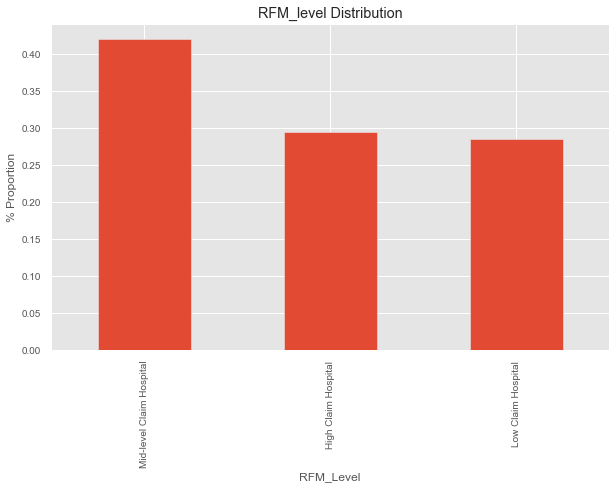

In [116]:
plt.figure(figsize=(10,6))
df_RFM['RFM_Level'].value_counts(normalize = True).plot(kind='bar')
plt.title('RFM_level Distribution')
plt.xlabel('RFM_Level')
plt.ylabel('% Proportion')
plt.show()

## Analyzing hospitals segments

In [117]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = df_RFM.groupby(['RFM_Level']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'TOTAL PRICE':['mean','count']}).round(1)

# Print the aggregated dataset
print(rfm_level_agg)

                         Recency Frequency TOTAL PRICE      
                            mean      mean        mean count
RFM_Level                                                   
High Claim Hospital         10.5      42.9    425342.8    89
Low Claim Hospital          78.8       2.2     16596.2    86
Mid-level Claim Hospital    43.5       7.8     68189.7   127


# Clustering using Kmeans

K Means Assumptions

- All variables have symmetrical (Normal) Distribution
- All Variables have same average value(approx)
- All Variables have same variance(approx)

In [118]:
data = df_RFM[['Recency','Frequency','TOTAL PRICE']]
data.head()

Recency  Frequency  TOTAL PRICE
PROVIDER NAME                                                  
 DOLAPO RADIOLOGY                    22          1     12240.00
ABIMBOLA HEALTH CENTRE                2          9     39330.00
ABROAD MEDICAL CENTRE                19         36    173910.25
ACRES HOSPITAL LTD                   28          6     92902.00
ADEOLA  HOSPITAL AND MATERNITY       85          8     28500.52

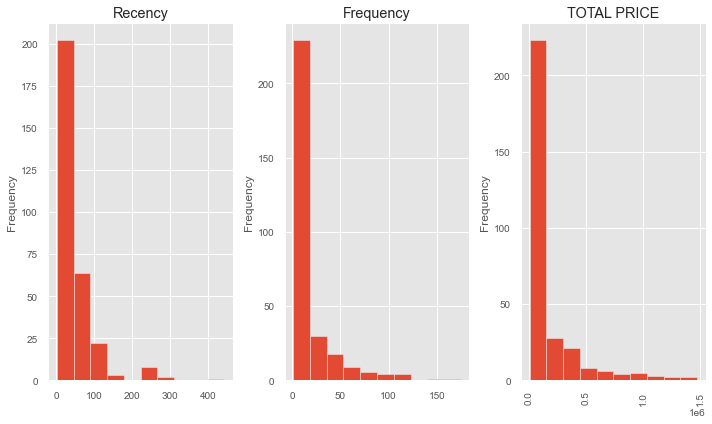

In [119]:
#Checking the distribution of Recency, Frequency nad Total Price
plt.figure(figsize=(10,6))

plt.subplot(1,3,1)
data['Recency'].plot(kind='hist')
plt.title('Recency')

plt.subplot(1,3,2)
data['Frequency'].plot(kind='hist')
plt.title('Frequency')

plt.subplot(1,3,3)
data['TOTAL PRICE'].plot(kind='hist')
plt.xticks(rotation = 90)
plt.title('TOTAL PRICE')

plt.tight_layout()
plt.show()

This shows that our Data is very skewed. This will cause bias in our cluster, so we have to perform log transformation to normalize the data

## Removing the skewness by performing log transformation on the variables

In [120]:
data_log = np.log(data)

In [121]:
data_log.head()

Recency  Frequency  TOTAL PRICE
PROVIDER NAME                                                   
 DOLAPO RADIOLOGY               3.091042   0.000000     9.412465
ABIMBOLA HEALTH CENTRE          0.693147   2.197225    10.579743
ABROAD MEDICAL CENTRE           2.944439   3.583519    12.066295
ACRES HOSPITAL LTD              3.332205   1.791759    11.439300
ADEOLA  HOSPITAL AND MATERNITY  4.442651   2.079442    10.257678

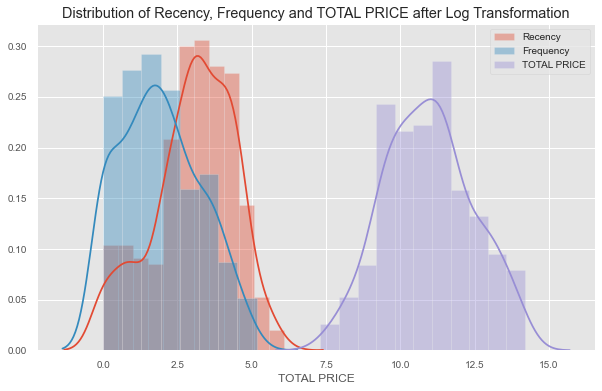

In [122]:
#Checking the distribution again after transformation
plt.figure(figsize=(10,6))

#plt.subplot(1,3,1)
sns.distplot(data_log['Recency'],label='Recency')

#plt.subplot(1,3,1)
sns.distplot(data_log['Frequency'],label='Frequency')

#plt.subplot(1,3,1)
sns.distplot(data_log['TOTAL PRICE'],label='TOTAL PRICE')

plt.title('Distribution of Recency, Frequency and TOTAL PRICE after Log Transformation')
plt.legend()
plt.show()

We can now see that our data is normally distributed now

## Standardization of Data

In [123]:
# Initialize and fit thw scaler
scaler = StandardScaler()
scaler.fit(data_log)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [124]:
# Scale and center the data
data_normalized = scaler.transform(data_log)
data_normalized = pd.DataFrame(data_normalized, index=data_log.index, columns=data_log.columns) # Create a pandas DataFrame

In [125]:
#summary statistics
data_normalized.describe().round(2)

Recency  Frequency  TOTAL PRICE
count   302.00     302.00       302.00
mean     -0.00      -0.00         0.00
std       1.00       1.00         1.00
min      -2.22      -1.42        -2.46
25%      -0.54      -0.91        -0.77
50%       0.07      -0.09        -0.02
75%       0.73       0.71         0.68
max       2.23       2.41         2.20

In [126]:
#calculate SSE for each k
sse={}
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(data_normalized)
    sse[k] = kmeans.inertia_ 

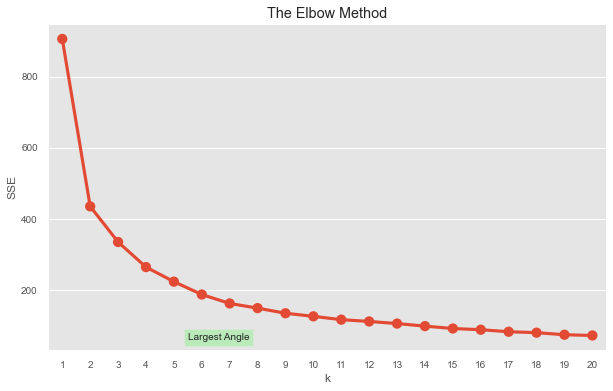

In [127]:
#Getting the value of K
plt.figure(figsize=(10,6))
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.text(4.5,60,"Largest Angle",bbox=dict(facecolor='lightgreen', alpha=0.5))
plt.show()

When K is 4, that's when the curve was made

In [128]:
# Initialize and fit KMeans
kmeans = KMeans(n_clusters=4, random_state=1) 
kmeans.fit(data_normalized)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=1, tol=0.0001, verbose=0)

In [129]:
# Extract and assign cluster labels to the raw data
cluster_labels = kmeans.labels_
data_rfm = data.assign(Cluster=cluster_labels)
data_rfm.head()

Recency  Frequency  TOTAL PRICE  Cluster
PROVIDER NAME                                                           
 DOLAPO RADIOLOGY                    22          1     12240.00        1
ABIMBOLA HEALTH CENTRE                2          9     39330.00        0
ABROAD MEDICAL CENTRE                19         36    173910.25        2
ACRES HOSPITAL LTD                   28          6     92902.00        3
ADEOLA  HOSPITAL AND MATERNITY       85          8     28500.52        3

In [166]:
data_rfm.to_csv('kmeans_cluster.csv')

In [130]:
# Group the data by cluster
grouped = data_rfm.groupby(['Cluster'])

In [131]:
# Calculate average RFM values and segment sizes per cluster value
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'TOTAL PRICE': ['mean', 'count']
  }).round(1)

Recency Frequency TOTAL PRICE      
           mean      mean        mean count
Cluster                                    
0           6.6      10.4    106126.0    53
1          61.8       1.7     14339.1    91
2          11.4      58.4    583142.2    57
3          65.5       9.5     76972.6   101

In [132]:
df

S/N  AGE SEX               PLAN      COMPANY  \
0        1   29   M     RED Individual    CORPORATE   
1        2   31   F  Yellow Individual    CORPORATE   
2        3   31   F  Yellow Individual    CORPORATE   
3        4   23   M  Yellow Individual    CORPORATE   
4        5   30   F     RED Individual    CORPORATE   
...    ...  ...  ..                ...          ...   
4995  4996    2   F      Yellow Family    CORPORATE   
4996  4997    2   F      Yellow Family    CORPORATE   
4997  4998   37   M     RED Individual       RETAIL   
4998  4999   29   F         RED Family  PARTNERSHIP   
4999  5000    5   M     RED Individual       RETAIL   

                      PROVIDER NAME PATIENT ENCOUNTER DATE  \
0                JOY HOSPITAL-LAGOS             1997-12-12   
1                CHARMAINE HOSPITAL             1997-12-24   
2                CHARMAINE HOSPITAL             1997-12-28   
3                 CILANTRO HOSPITAL             1997-12-19   
4                JOY HOSPITAL-LAGOS             1997-12-01   
...                             ...                    ...   
4995          KING OF BOYS HOSPITAL             1999-02-22   
4996          KING OF BOYS HOSPITAL             1999-02-04   
4997  JONAH SPECIALIST HOSPITAL LTD             1999-02-25   
4998               MORTAL HOSPITAL              1999-02-25   
4999  JONAH SPECIALIST HOSPITAL LTD             1999-02-25   

     MEDICAL CLAIMS SUBMISSION DATE PAYMENT DATE SERVICE TYPE  \
0                        1998-01-02   1998-01-02   Outpatient   
1                        1998-01-02   1998-01-02   Outpatient   
2                        1998-01-02   1998-01-02    Inpatient   
3                        1998-01-03   1998-01-09   Outpatient   
4                        1998-01-04   1998-01-09   Outpatient   
...                             ...          ...          ...   
4995                     1999-02-27   1999-02-27   Outpatient   
4996                     1999-02-27   1999-02-27   Outpatient   
4997                     1999-02-27   1999-02-27   Outpatient   
4998                     1999-02-27   1999-02-27   Outpatient   
4999                     1999-02-27   1999-02-27   Outpatient   

                                             DIAGNOSIS  TOTAL PRICE  \
0                              ACUTE MALARIA WITH URTI     17000.00   
1                       LEFT MODERATE TO PROFOUND SNHL     20000.00   
2                       LEFT MODERATE TO PROFOUND SNHL     15000.00   
3                                                 URTI      2160.00   
4                                         PLASMODIASIS     10399.99   
...                                                ...          ...   
4995                                 PAPULAR URTICARIA      2260.00   
4996                  COUGH, CATARRH, NASAL CONGESTION      3480.00   
4997  SEPSIS,MALARIA,UPPER RESPIRATORY TRACT INFECTION      4057.83   
4998                              ?CYESIS, + ENTERITIS      3893.58   
4999                                     CARBUNCULOSIS      2995.00   

      age_category                 diag  Submission_Gap  NUMBEROFCLAIMS  
0     Young Adults         MALARIA,URTI              21              44  
1     Young Adults        PROFOUND,SNHL               9              87  
2     Young Adults        PROFOUND,SNHL               5              87  
3     Young Adults                 URTI              15              46  
4     Young Adults         PLASMODIASIS              34              44  
...            ...                  ...             ...             ...  
4995    adolescent    PAPULAR,URTICARIA               5              19  
4996    adolescent  COUGH,CATARRH,NASAL              23              19  
4997    Old Adults       SEPSIS,MALARIA               2              62  
4998  Young Adults     CYESIS,ENTERITIS               2              94  
4999    adolescent        CARBUNCULOSIS               2              62  

[5000 rows x 16 columns]

# Total Price Prediction

We will predict the total price using XGBoost

In [133]:
#Subset the column we will use for the machine learning
df_ml = df[['AGE','age_category','SEX','PLAN','COMPANY','PROVIDER NAME','SERVICE TYPE','diag','Submission_Gap','NUMBEROFCLAIMS', 'TOTAL PRICE']]

Our model cannot understand categorical features without encoding

In [134]:
# Determination categorical features
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical_columns = []
features = df_ml.columns.values.tolist()
for col in features:
    if df_ml[col].dtype in numerics: continue
    categorical_columns.append(col)

In [135]:
# Encoding categorical features
for col in categorical_columns:
    if col in df_ml.columns:
        le = LabelEncoder()
        le.fit(list(df_ml[col].astype(str).values))
        df_ml[col] = le.transform(list(df_ml[col].astype(str).values))

In [136]:
df_ml.head()

AGE  age_category  SEX  PLAN  COMPANY  PROVIDER NAME  SERVICE TYPE  diag  \
0   29             4    1    42        0            130             1  1398   
1   31             4    0    56        0             46             1  2067   
2   31             4    0    56        0             46             0  2067   
3   23             4    1    56        0             49             1  2620   
4   30             4    0    42        0            130             1  1914   

   Submission_Gap  NUMBEROFCLAIMS  TOTAL PRICE  
0              21              44     17000.00  
1               9              87     20000.00  
2               5              87     15000.00  
3              15              46      2160.00  
4              34              44     10399.99

In [137]:
#Checking for missing value
df_ml.isnull().values.any()

False

In [138]:
#Checking information on our datan to ensure they're in proper data format
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   AGE             5000 non-null   int64  
 1   age_category    5000 non-null   int64  
 2   SEX             5000 non-null   int64  
 3   PLAN            5000 non-null   int64  
 4   COMPANY         5000 non-null   int64  
 5   PROVIDER NAME   5000 non-null   int64  
 6   SERVICE TYPE    5000 non-null   int64  
 7   diag            5000 non-null   int64  
 8   Submission_Gap  5000 non-null   int64  
 9   NUMBEROFCLAIMS  5000 non-null   int64  
 10  TOTAL PRICE     5000 non-null   float64
dtypes: float64(1), int64(10)
memory usage: 429.8 KB


## Some Exploratory Data Analysis (EDA)

In [139]:
#Correlation table
df_ml.corr()

AGE  age_category       SEX      PLAN   COMPANY  \
AGE             1.000000     -0.539640  0.067883  0.059767  0.140508   
age_category   -0.539640      1.000000 -0.101482 -0.041966 -0.109379   
SEX             0.067883     -0.101482  1.000000 -0.018659 -0.061589   
PLAN            0.059767     -0.041966 -0.018659  1.000000  0.433737   
COMPANY         0.140508     -0.109379 -0.061589  0.433737  1.000000   
PROVIDER NAME  -0.025852     -0.061825 -0.068054 -0.106094 -0.015209   
SERVICE TYPE    0.030389     -0.005349  0.005537  0.055217  0.035726   
diag           -0.041840      0.034451  0.028699  0.083916  0.016140   
Submission_Gap -0.010904      0.006727 -0.008934 -0.013209 -0.046894   
NUMBEROFCLAIMS -0.016873      0.010135 -0.019687  0.031464  0.039289   
TOTAL PRICE    -0.011127     -0.007463 -0.085038 -0.097464 -0.053687   

                PROVIDER NAME  SERVICE TYPE      diag  Submission_Gap  \
AGE                 -0.025852      0.030389 -0.041840       -0.010904   
age_category        -0.061825     -0.005349  0.034451        0.006727   
SEX                 -0.068054      0.005537  0.028699       -0.008934   
PLAN                -0.106094      0.055217  0.083916       -0.013209   
COMPANY             -0.015209      0.035726  0.016140       -0.046894   
PROVIDER NAME        1.000000     -0.002234 -0.094895       -0.081132   
SERVICE TYPE        -0.002234      1.000000 -0.003599       -0.048147   
diag                -0.094895     -0.003599  1.000000        0.077453   
Submission_Gap      -0.081132     -0.048147  0.077453        1.000000   
NUMBEROFCLAIMS       0.129570      0.065713  0.050205        0.113568   
TOTAL PRICE          0.028224     -0.349180 -0.027983        0.005791   

                NUMBEROFCLAIMS  TOTAL PRICE  
AGE                  -0.016873    -0.011127  
age_category          0.010135    -0.007463  
SEX                  -0.019687    -0.085038  
PLAN                  0.031464    -0.097464  
COMPANY               0.039289    -0.053687  
PROVIDER NAME         0.129570     0.028224  
SERVICE TYPE          0.065713    -0.349180  
diag                  0.050205    -0.027983  
Submission_Gap        0.113568     0.005791  
NUMBEROFCLAIMS        1.000000    -0.068014  
TOTAL PRICE          -0.068014     1.000000

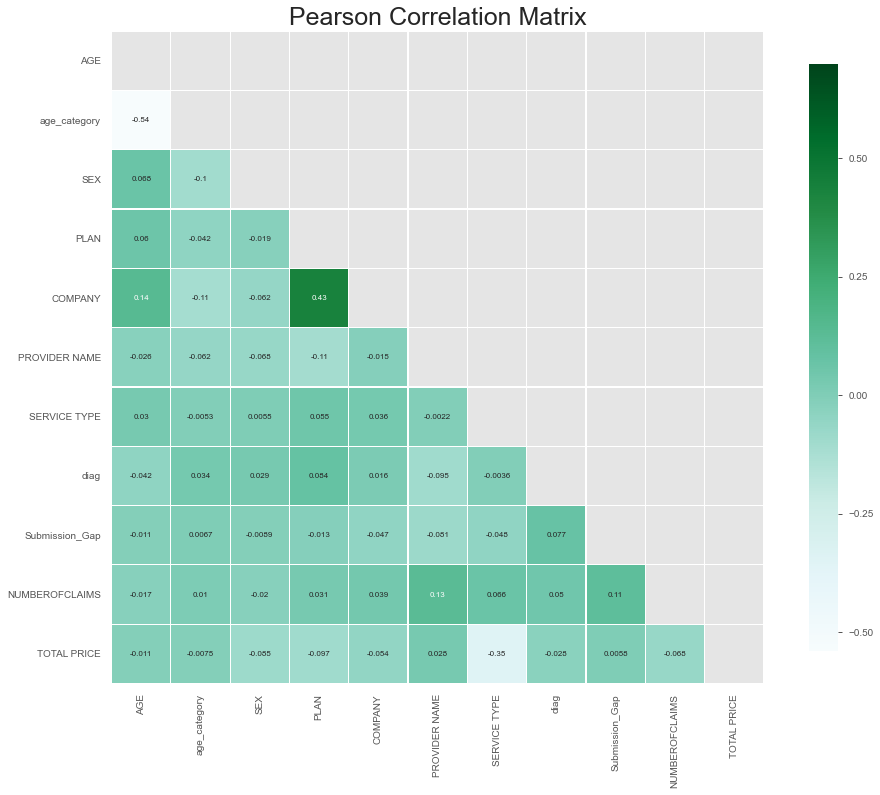

In [140]:
#Visualizing the correlation between the features
mask = np.zeros_like(df_ml[features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(df_ml[features].corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn",
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9});

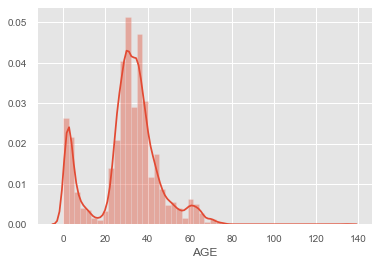

In [141]:
#Age distribution
sns.distplot(df_ml['AGE'])

In [142]:
#Our data report
pp.ProfileReport(df_ml)

## Create Dummy Variable

In [143]:
#dummies
df_ml = pd.get_dummies(data=df_ml, columns=['age_category', 'SEX', 'COMPANY','SERVICE TYPE'])
df_ml.head()

AGE  PLAN  PROVIDER NAME  diag  Submission_Gap  NUMBEROFCLAIMS  \
0   29    42            130  1398              21              44   
1   31    56             46  2067               9              87   
2   31    56             46  2067               5              87   
3   23    56             49  2620              15              46   
4   30    42            130  1914              34              44   

   TOTAL PRICE  age_category_0  age_category_1  age_category_2  \
0     17000.00               0               0               0   
1     20000.00               0               0               0   
2     15000.00               0               0               0   
3      2160.00               0               0               0   
4     10399.99               0               0               0   

   age_category_3  age_category_4  age_category_5  SEX_0  SEX_1  COMPANY_0  \
0               0               1               0      0      1          1   
1               0               1               0      1      0          1   
2               0               1               0      1      0          1   
3               0               1               0      0      1          1   
4               0               1               0      1      0          1   

   COMPANY_1  COMPANY_2  SERVICE TYPE_0  SERVICE TYPE_1  
0          0          0               0               1  
1          0          0               0               1  
2          0          0               1               0  
3          0          0               0               1  
4          0          0               0               1

In [144]:
#Split the data into train and test set
train,test = split_by_fractions(df_ml, [0.8,0.2])

In [145]:
#Separate the features Column from target variable in train set
X = train.loc[:, train.columns != 'TOTAL PRICE']
X.head()

AGE  PLAN  PROVIDER NAME  diag  Submission_Gap  NUMBEROFCLAIMS  \
1501   63    56            282   966               6              82   
2586   41    42             53     0               7               3   
2653   39    32            111  2551              21              26   
1055   51    32              2  2592             104              36   
705    29    32            170  2372              16              38   

      age_category_0  age_category_1  age_category_2  age_category_3  \
1501               0               0               1               0   
2586               0               0               1               0   
2653               0               0               1               0   
1055               0               0               1               0   
705                0               0               0               0   

      age_category_4  age_category_5  SEX_0  SEX_1  COMPANY_0  COMPANY_1  \
1501               0               0      1      0          0          0   
2586               0               0      0      1          1          0   
2653               0               0      0      1          0          1   
1055               0               0      0      1          0          1   
705                1               0      1      0          0          1   

      COMPANY_2  SERVICE TYPE_0  SERVICE TYPE_1  
1501          1               0               1  
2586          0               0               1  
2653          0               0               1  
1055          0               1               0  
705           0               0               1

In [146]:
#target variable for ttain set
y = train.loc[:, train.columns == 'TOTAL PRICE']
y.head()

TOTAL PRICE
1501      46325.0
2586       2120.0
2653       7094.0
1055       7200.0
705        2600.0

In [147]:
#Separate the features Column from target variable in test set
X_test = test.loc[:, test.columns != 'TOTAL PRICE']

In [148]:
#target variable for test set
y_test = test.loc[:, test.columns == 'TOTAL PRICE']

In [149]:
#Data Scaling
scaler = StandardScaler()
train0 = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

In [150]:
train0.head()

AGE      PLAN  PROVIDER NAME      diag  Submission_Gap  \
0  2.131182  1.521537       1.537817 -0.594552       -0.636881   
1  0.686880  0.558572      -1.195602 -1.648671       -0.590272   
2  0.555580 -0.129261      -0.503295  1.135031        0.062258   
3  1.343381 -0.129261      -1.804355  1.179771        3.930829   
4 -0.100921 -0.129261       0.200948  0.939702       -0.170788   

   NUMBEROFCLAIMS  age_category_0  age_category_1  age_category_2  \
0        0.601740       -0.168944       -0.114766        1.422474   
1       -1.191061       -0.168944       -0.114766        1.422474   
2       -0.669106       -0.168944       -0.114766        1.422474   
3       -0.442169       -0.168944       -0.114766        1.422474   
4       -0.396782       -0.168944       -0.114766       -0.703001   

   age_category_3  age_category_4  age_category_5    SEX_0    SEX_1  \
0       -0.129525       -0.957406       -0.392939  1.09942 -1.09942   
1       -0.129525       -0.957406       -0.392939 -0.90957  0.90957   
2       -0.129525       -0.957406       -0.392939 -0.90957  0.90957   
3       -0.129525       -0.957406       -0.392939 -0.90957  0.90957   
4       -0.129525        1.044489       -0.392939  1.09942 -1.09942   

   COMPANY_0  COMPANY_1  COMPANY_2  SERVICE TYPE_0  SERVICE TYPE_1  
0  -1.081838  -0.591594   1.990673       -0.268512        0.268512  
1   0.924352  -0.591594  -0.502343       -0.268512        0.268512  
2  -1.081838   1.690349  -0.502343       -0.268512        0.268512  
3  -1.081838   1.690349  -0.502343        3.724230       -3.724230  
4  -1.081838   1.690349  -0.502343       -0.268512        0.268512

In [151]:
len(train0)

4000

In [152]:
y.head()

TOTAL PRICE
1501      46325.0
2586       2120.0
2653       7094.0
1055       7200.0
705        2600.0

In [153]:
#Split data into train and test
train2, test2, target_train, target_test = train_test_split(train0, y, test_size=0.3, random_state=0)

In [154]:
#Determining the best parameters
acc_train_rmse = []
acc_test_rmse = []

xgb_clf = xgb.XGBRegressor({'objective': 'reg:squarederror'}) 
parameters = {'n_estimators': [60, 100, 120, 140], 
              'learning_rate': [0.01, 0.1],
              'max_depth': [5, 7],
              'reg_lambda': [0.5]}
xgb_reg = GridSearchCV(estimator=xgb_clf, param_grid=parameters, cv=5, n_jobs=-1).fit(train2, target_train)
print("Best score: %0.3f" % xgb_reg.best_score_)
print("Best parameters set:", xgb_reg.best_params_)

[15:49:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best score: -0.068
Best parameters set: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'reg_lambda': 0.5}


In [155]:
acc_boosting_model(2,xgb_reg,train2,test2)

target =  [[ 4800. ]
 [ 3671.6]
 [10000. ]
 [ 5580. ]
 [ 3742. ]]
ytrain =  [4076.8875 4042.7727 3990.8574 4757.2324 4605.7603]
acc(rmse) for train = 1225887.78
acc(rmse) for test = 1579195.3


In [156]:
#split train set into Xtrain and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=12)

In [157]:
#Scaling the X_train
X_train = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns)

In [158]:
#%% split training set to validation set 
data_tr  = xgb.DMatrix(X_train, label = y_train)
data_cv  = xgb.DMatrix(X_val, label = y_val)
evallist = [(data_tr, 'train'), (data_cv, 'valid')]

In [159]:
params = {'max_depth':5, #maximum depth of a tree
         'objective':'reg:squarederror',
         'eta'      :0.3,
         'subsample':0.8,#SGD will use this percentage of data
         'lambda '  :4, #L2 regularization term,>1 more conservative 
         'colsample_bytree ':0.9,
         'colsample_bylevel':1,
         'min_child_weight': 10}
modelx = xgb.train(params, data_tr, num_boost_round=200, evals = evallist,
                  early_stopping_rounds=30, maximize=False, 
                  verbose_eval=10)

print('score = %1.5f, n_boost_round =%d.'%(modelx.best_score,modelx.best_iteration))

[0]	train-rmse:17956.6	valid-rmse:14978.2
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
[10]	train-rmse:13353.3	valid-rmse:41866.8
[20]	train-rmse:11947.1	valid-rmse:44003.2
[30]	train-rmse:10973.9	valid-rmse:46564
Stopping. Best iteration:
[3]	train-rmse:15213.1	valid-rmse:13243.5

score = 13243.49805, n_boost_round =3.


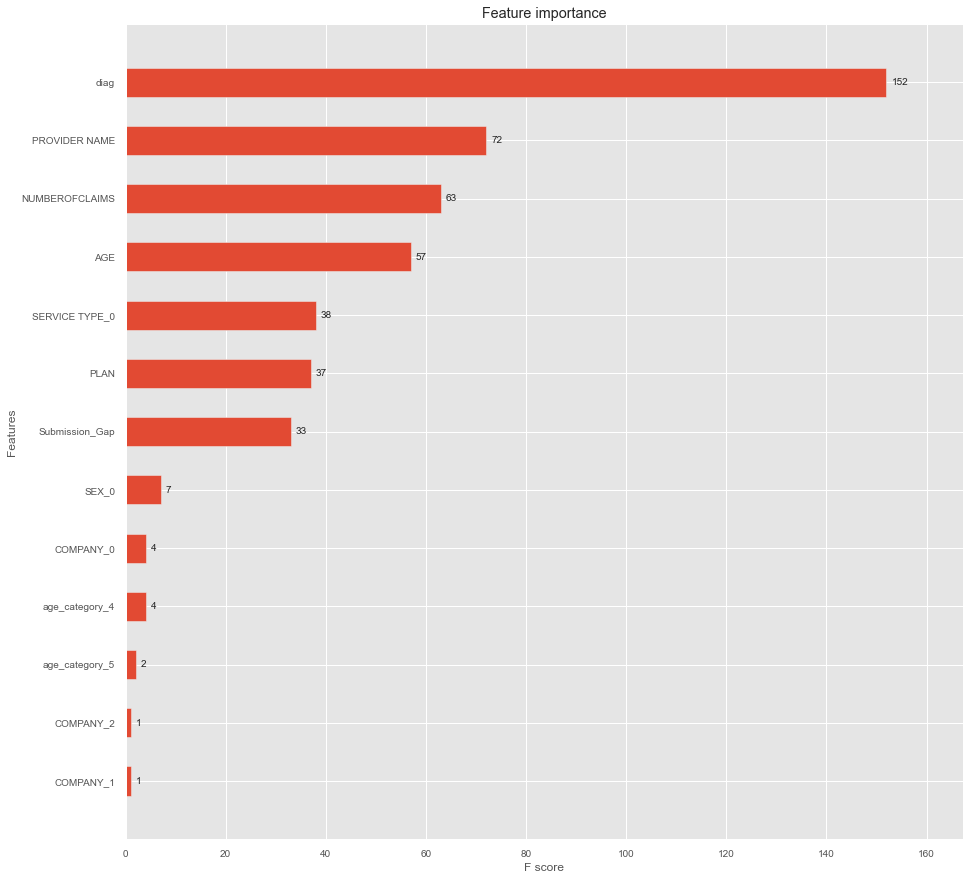

In [160]:
fig =  plt.figure(figsize = (15,15))
axes = fig.add_subplot(111)
xgb.plot_importance(modelx,ax = axes,height = 0.5)
plt.show();plt.close()

Unsurprisingly, Diagnosis has the biggest influence on the total price

## Get predictions

In [161]:
#Scale the X_test
testn = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

In [162]:
#Create xgb dataset
data_test  = xgb.DMatrix(testn, label = y_test)

In [163]:
# XGB Regression model for train
xgb_predict = modelx.predict(data_test)
xgb_predict[:3]

array([ 5685.7173, 13810.539 ,  4703.244 ], dtype=float32)

In [164]:
#Prediction Comparison with the real Values
final_df = y_test.values
final_df = pd.DataFrame(final_df,columns=['Real_price'])
final_df['predicted_prices'] = xgb_predict.astype(int)
final_df['difference'] = abs(final_df['Real_price'] - final_df['predicted_prices']).astype(int)
final_df.head(10)

Real_price  predicted_prices  difference
0     7500.00              5685        1815
1    20220.30             13810        6410
2     7975.00              4703        3272
3     5320.00             14491        9171
4     5415.00              5560         145
5    11330.00             88765       77435
6     3472.00              5600        2128
7     8448.00             13058        4610
8     2990.00              5229        2239
9     5789.25              5494         295

This can be improved on with more data and further feature engineering

In [165]:
final_df.to_csv('price_prediction.csv')